In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

In [2]:
JYOTHILAB = yf.download("JYOTHYLAB.NS",start='2023-03-31',end='2024-04-01')['Adj Close']

AJANTPHARM = yf.download("AJANTPHARM.NS",start='2023-03-31',end='2024-04-01')['Adj Close']

PATANJALI = yf.download("PATANJALI.NS",start='2023-03-31',end='2024-04-01')['Adj Close']

TATASTEEL = yf.download("TATASTEEL.NS",start='2023-03-31',end='2024-04-01')['Adj Close']

EIDPARRY = yf.download("EIDPARRY.NS",start='2023-03-31',end='2024-04-01')['Adj Close']

GLS = yf.download("GLS.BO",start='2023-03-31',end='2024-04-01')['Adj Close']

INDIACEM = yf.download("INDIACEM.NS",start='2023-03-31',end='2024-04-01')['Adj Close']

TBILL = pd.read_csv("India 1-Year Bond Yield Historical Data.csv")

MSFT = yf.download("MSFT",start='2023-04-01',end='2024-03-31')['Adj Close']

BTC = yf.download("BTC-USD",start='2023-04-01',end='2024-03-31')['Adj Close']



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
TBILL['Date'] = pd.to_datetime(TBILL['Date'], format='%d-%m-%Y')
TBILL.set_index('Date', inplace=True)
TBILL = TBILL.sort_index()
TBILL = TBILL["Price"]
TBILL

Date
2023-04-03    7.124
2023-04-05    7.114
2023-04-06    6.950
2023-04-10    6.920
2023-04-11    6.935
              ...  
2024-03-21    7.084
2024-03-22    7.099
2024-03-26    7.107
2024-03-27    7.089
2024-03-28    6.975
Name: Price, Length: 240, dtype: float64

### Domestic Portfolio

In [4]:
portfolio_d = pd.concat([JYOTHILAB,PATANJALI,AJANTPHARM,TATASTEEL,EIDPARRY,GLS,INDIACEM, TBILL],axis=1)
portfolio_d.columns = ['JYOTHILAB','PATANJALI','AJANTPHARM','TATASTEEL', 'EIDPARRY','GLS','INDIACEM', 'TBILL']

### International Portfolio

In [5]:
portfolio_i = pd.concat([JYOTHILAB,AJANTPHARM,PATANJALI,TATASTEEL,EIDPARRY,GLS,INDIACEM, TBILL, MSFT, BTC],axis=1)
portfolio_i.columns = ['JYOTHILAB','AJANTPHARM','PATANJALI','TATASTEEL', 'EIDPARRY','GLS','INDIACEM', 'TBILL', 'MSFT', 'BTC']

### Portfolio Returns

In [6]:
portfolio_returns_d = portfolio_d.pct_change(1, fill_method=None).dropna()

portfolio_returns_i = portfolio_i.pct_change(1, fill_method=None).dropna()

### Log returns 

In [7]:
log_rets_d = np.log(1 + portfolio_d.pct_change(1, fill_method=None))
log_rets_d.dropna(inplace=True)
log_rets_cov = log_rets_d.cov() 

In [8]:
log_rets_i = np.log(1 + portfolio_i.pct_change(1, fill_method=None))
log_rets_i.dropna(inplace=True)
log_rets_cov = log_rets_i.cov() 


### Weighted Returns

In [9]:
N_d = len(portfolio_returns_d.columns)
equal_weights_d = N_d*[1/N_d]

In [10]:
N_i = len(portfolio_returns_i.columns)
equal_weights_i = N_i*[1/N_i]

In [11]:
def gen_weights(N):
    weights = np.random.random(N)
    return weights/ np.sum(weights)

def calculate_returns(weights,log_rets):
    return np.sum(log_rets.mean()*weights) * 252

def calculate_volatility(weights,log_rets_cov):
    annualized_cov = np.dot(log_rets_cov*252,weights)
    vol = np.dot(weights.transpose(),annualized_cov)
    return np.sqrt(vol)

### Tangency Weights

In [12]:
# Domestic
tangency_weights_d = [1.16615716e-01, 2.91618928e-01, 0.00000000e+00, 3.42806878e-01,
                      1.62630326e-18, 2.48958478e-01, 6.83047369e-18, 0.00000000e+00]

# International
tangency_weights_i = [7.30949039e-02, 1.46279021e-01, 7.56925115e-02, 1.20176680e-01,
                      0.00000000e+00, 1.93546018e-01, 0.00000000e+00, 6.28837260e-18,
                       2.89786764e-01, 1.01424102e-01]

### Weighted Returns

In [13]:
weighted_returns_d = log_rets_d * tangency_weights_d

weighted_returns_i = log_rets_i * tangency_weights_i

### Tangency Portfolio Daily Returns

In [14]:
tangency_portfolio_daily_returns_d = weighted_returns_d.sum(axis=1)

tangency_portfolio_daily_returns_i = weighted_returns_i.sum(axis=1)

### Tangency Portfolio Cummulative Returns

In [15]:
tangency_cumulative_returns_d = (1 + tangency_portfolio_daily_returns_d).cumprod()

tangency_cumulative_returns_i = (1 + tangency_portfolio_daily_returns_i).cumprod()

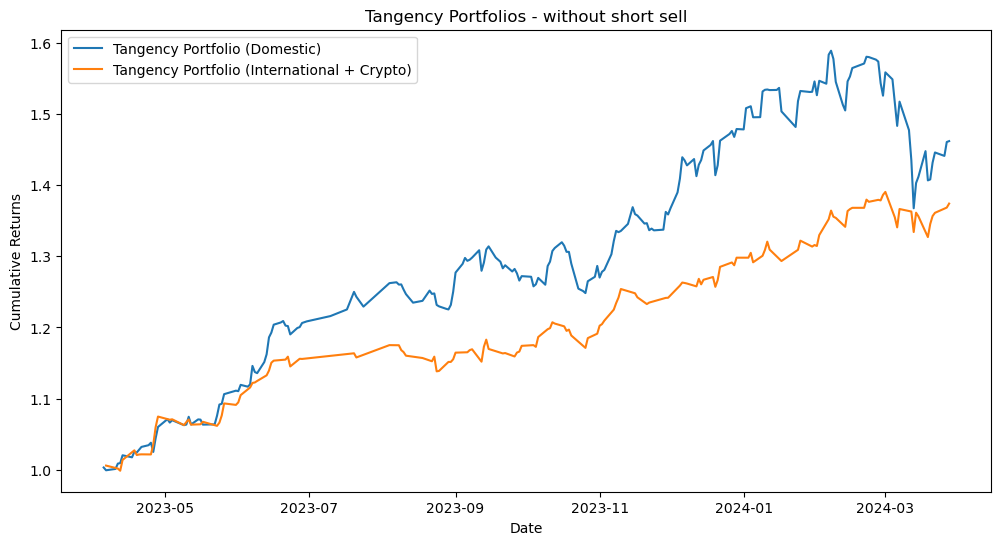

In [16]:
plt.figure(figsize=(12,6))
plt.plot(tangency_cumulative_returns_d, label='Tangency Portfolio (Domestic)')
plt.plot(tangency_cumulative_returns_i, label='Tangency Portfolio (International + Crypto)')
plt.title('Tangency Portfolios - without short sell')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()